In [1]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# Loading Datasets

In [5]:
df = pd.read_csv("./NLP_Data/train.csv")
df_test = pd.read_csv("./NLP_Data/test.csv")

In [6]:
df.shape, df_test.shape

((30336, 17), (29272, 16))

In [7]:
df.head()

,ID,Place,location,date,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,overall
0,1,startup_1,NaN,"Dec 11, 2018",Current Employee,Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,NaN,4.0,5.0,5.0,4.0,5.0,0,5.0
1,2,startup_1,"Mountain View, CA","Jun 21, 2013",Former Employee,Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,2.0,3.0,3.0,5.0,3.0,2094,5.0
2,3,startup_1,"New York, NY","May 10, 2014",Current Employee,Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,4.0,5.0,5.0,4.0,949,5.0
3,4,startup_1,"Mountain View, CA","Feb 8, 2015",Current Employee,Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,2.0,5.0,5.0,4.0,5.0,498,4.0
4,10,startup_1,NaN,"Dec 9, 2018",Current Employee,Anonymous Employee,Execellent for engineers,Impact driven. Best tech in the world.,Size matters. Engineers are a bit disconnected...,NaN,5.0,5.0,5.0,5.0,5.0,0,4.0


In [8]:
def categorical_feature_distribution(feature_name, target_name, top_counts=None):
    material_trace = []

    for material in df[target_name].unique():
        if not top_counts:
            _tmp_material = df[df[target_name]==material][feature_name].value_counts()
        else:
            _tmp_material = df[df[target_name]==material][feature_name].value_counts()[:top_counts]
            
        tmp_trace = go.Bar(
            x=_tmp_material.index,
            y=_tmp_material.values,
            name=material
        )
        material_trace.append(tmp_trace)

    layout = go.Layout(
        barmode='group',
        title=feature_name + " VS " + target_name + " - Distribution ",
        yaxis=dict(
            title='Counts',
        ),
        xaxis=dict(
            title=feature_name,
        )
        
    )

    fig = go.Figure(data=material_trace, layout=layout)
    iplot(fig) #, filename='grouped-bar')
    
    


# Understand the data

In [9]:
df['overall'].iplot(kind='hist', xTitle='overall',
                  yTitle='count', title='Target Distribution')

In [10]:
categorical_feature_distribution('Place','overall')

In [11]:
categorical_feature_distribution('job_title','overall')

In [12]:
categorical_feature_distribution('location','overall')

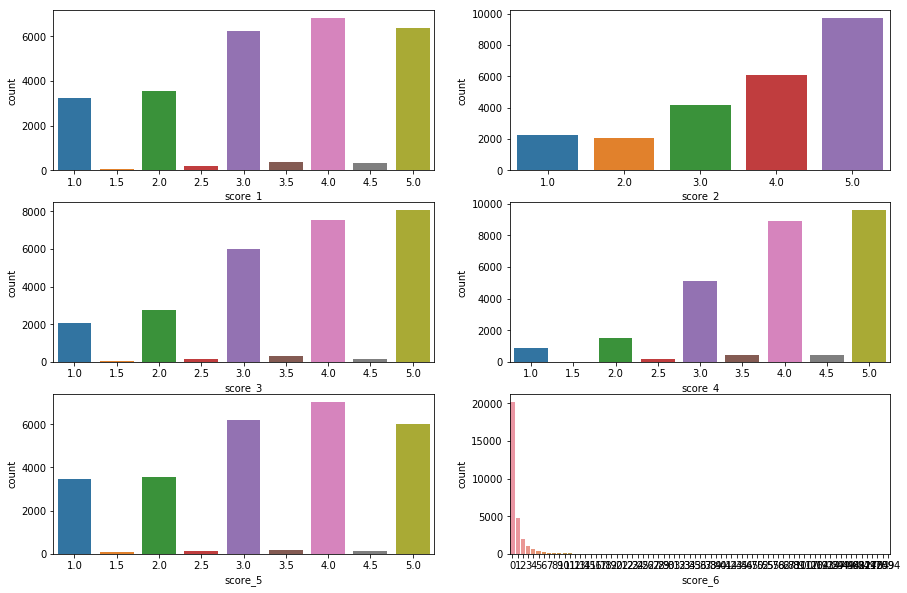

In [13]:

plt.figure(figsize=(15,10))
plt.subplot(3,2,1)
sns.countplot(x='score_1', data=df);

plt.subplot(3,2,2)
sns.countplot(x='score_2', data=df);

plt.subplot(3,2,3)
sns.countplot(x='score_3', data=df);

plt.subplot(3,2,4)
sns.countplot(x='score_4', data=df);

plt.subplot(3,2,5)
sns.countplot(x='score_5', data=df);

plt.subplot(3,2,6)
sns.countplot(x='score_6', data=df);


In [14]:
def create_wordcloud(target, feature):
    text = " ".join(review for review in df[df['overall'] == target][feature].dropna())
    print ("There are {} words in the combination of all review.".format(len(text)))

    # Create the wordcloud object
    wordcloud = WordCloud(width=1024, height=480, margin=0).generate(text)

    # Display the generated image:
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

There are 168174 words in the combination of all review.


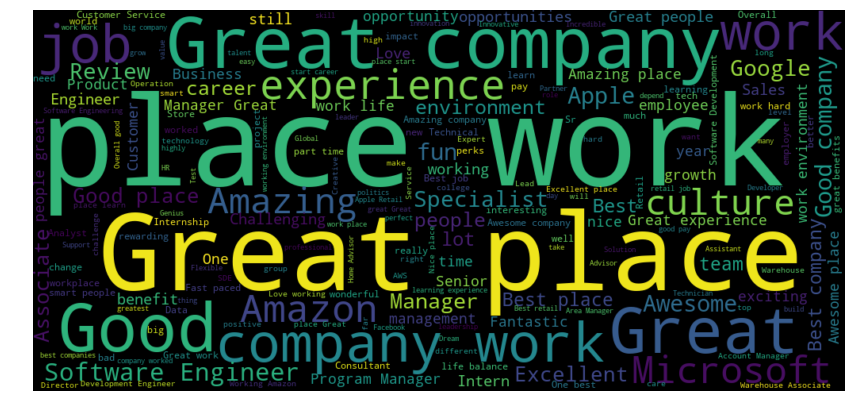

In [15]:
create_wordcloud(5.0, 'summary')

There are 17337 words in the combination of all review.


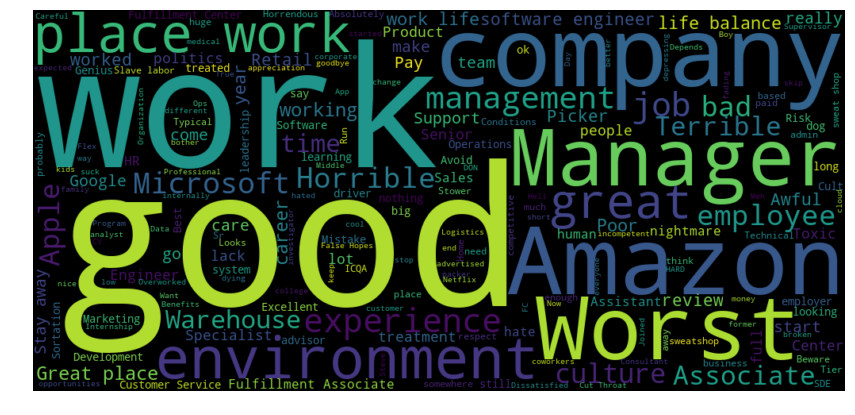

In [16]:
create_wordcloud(1.0, 'summary')

There are 814267 words in the combination of all review.


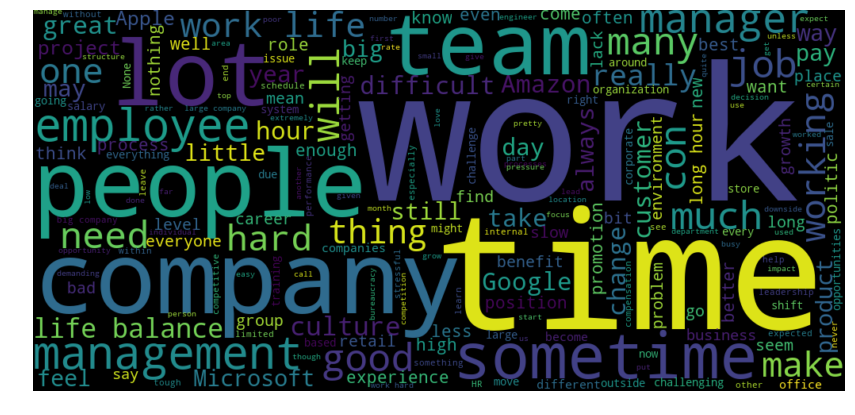

In [17]:
create_wordcloud(5.0, 'negatives')

There are 233526 words in the combination of all review.


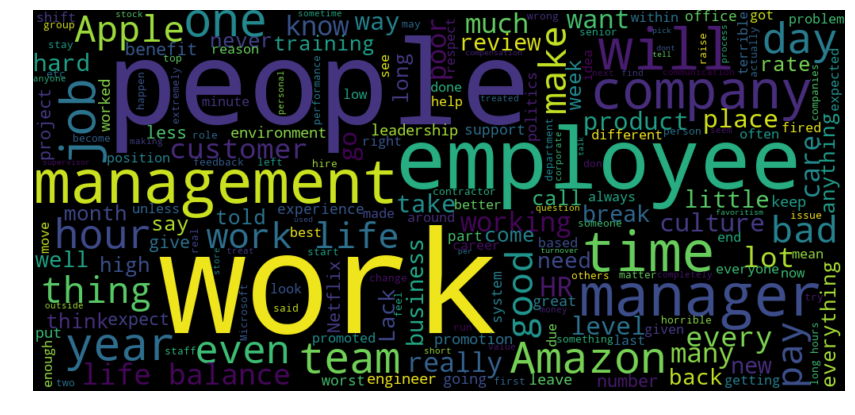

In [18]:
create_wordcloud(1.0, 'negatives')

# Handling missing values

In [18]:
(df.isnull().sum() / df.shape[0]) * 100

ID                 0.000000
Place              0.000000
location          37.097838
date               0.000000
status             0.000000
job_title          0.000000
summary            0.171414
positives          0.000000
negatives          0.000000
advice_to_mgmt    43.766482
score_1           10.502373
score_2           19.943302
score_3           10.446334
score_4           10.518855
score_5           11.488001
score_6            0.000000
overall            0.000000
dtype: float64

In [19]:
(df_test.isnull().sum() / df_test.shape[0]) * 100

ID                 0.000000
Place              0.000000
location          32.881252
date               0.000000
status             0.000000
job_title          0.000000
summary            0.174228
positives          0.000000
negatives          0.003416
advice_to_mgmt    42.767833
score_1            0.000000
score_2            0.000000
score_3            0.000000
score_4            0.000000
score_5            0.000000
score_6            0.000000
dtype: float64

In [20]:
for col in ['summary', 'positives', 'negatives', 'advice_to_mgmt']:
    print(col)
    df[col].fillna("nocomments", inplace=True)
    df_test[col].fillna("nocomments", inplace=True)

summary
positives
negatives
advice_to_mgmt


In [25]:
df['location'].fillna("unknown", inplace=True )
df_test['location'].fillna("unknown", inplace=True )

In [21]:
for i in range(1,6):
    col = "score_"+str(i)
    
    mode_fill = df[col].mode()[0]
    print(col ,":", mode_fill)
    df[col] = df[col].fillna(mode_fill)
    df_test[col] = df_test[col].fillna(mode_fill)
    

score_1 : 4.0
score_2 : 5.0
score_3 : 5.0
score_4 : 5.0
score_5 : 4.0


# PIPELINE 

![pipeline_rating](https://github.com/asingleneuron/Ericsson-Machine-Learning-Challenge/blob/master/images/pipeline_rating.png?raw=True)

> **Create new feature "INFO"  by concatenating summary, positives , negatives, advice_to_mgmt** 

In [23]:
df['info'] = df['summary'] + " " + df['advice_to_mgmt'] + " " + df['positives']+ " " + df['negatives']
df_test['info'] = df_test['summary'] + " " + df_test['advice_to_mgmt'] + " " + df_test['positives']+ " " + df_test['negatives']


> **Numerical encode categorical features**

In [27]:
categorical_features = ['Place', 'location', 'status', 'job_title']

for col in categorical_features:
    print(col)
    le = LabelEncoder()
    le.fit(list(df[col])+ list(df_test[col]))
    df[col] = le.transform(df[col])
    df_test[col] = le.transform(df_test[col])
    

Place
location
status
job_title


> **Add some functions and Transformer class**

In [28]:
stop_words = set(stopwords.words('english'))

In [29]:
def tokenize(text):
    '''
        Input: text
        Returns: clean tokens
        Desc:
            Generates a clean token of text (words) by first getting words from the text.
            Applies Lemmatization on the words.
            Normalize the text by lowering it and removes the extra spaces.
    '''
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        #
        if tok not in string.punctuation and tok not in stop_words:
            clean_tok = tok.lower().strip()
            #clean_tok = lemmatizer.lemmatize(tok).lower().strip()
            clean_tokens.append(clean_tok)

    return clean_tokens

In [30]:
class TextLengthExtractor(BaseEstimator, TransformerMixin):
    '''
        Input: X
        return: pandas series of length of text
        TextLengthExtractor is a transformer , can be used in pipeline to extract the length of the text from a given input.
        Input can be an array of text or pandas Series.
    '''

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.Series(X).apply(lambda x: len(x)).values.reshape(-1,1)


class WordCountExtractor(BaseEstimator, TransformerMixin):
    '''
        Input: X
        return: pandas series of word count
        WordCountExtractor is a transformer , can be used in pipeline to extract the number of words of the text from a given input.
        Input can be an array of text or pandas Series.
    '''
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.Series(X).apply(lambda x: len(x.split())).values.reshape(-1,1)


class MessageExtractor(BaseEstimator, TransformerMixin):        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X["info"]
    
    
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor     
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    
    def transform( self, X, y = None ):
        return X[ ['Place', 
                   'location', 
                   'status', 
                   'job_title' , 
                   'score_1', 
                   'score_2',
                   'score_3', 
                   'score_4', 
                   'score_5', 
                   'score_6', 
                  ] ] 

In [32]:
pipeline = Pipeline([
        ('features', FeatureUnion([

            
            ('text_pipeline', Pipeline([
                ('text', MessageExtractor()),
                ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
            ])),
            
            ('CheckoutType', Pipeline([
                ('checkout', FeatureSelector()),
                
            ])),

        ])),

        ('clf', XGBClassifier(seed=1)) 
        
]) 

parameters = {
     'features__text_pipeline__tfidf__ngram_range': ((1, 2),),
     'features__text_pipeline__tfidf__max_df': (0.6,),
     'features__text_pipeline__tfidf__max_features': [5000,],
     'features__text_pipeline__tfidf__use_idf': (False,),    
     'clf__n_estimators': [100],
     'clf__max_depth': [4],
  
}

grid = GridSearchCV(pipeline, parameters, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=5)


In [33]:
X = df.drop('overall', axis=1)
y = df.overall

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.3, random_state=1)

In [35]:
grid.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__max_depth=4, features__text_pipeline__tfidf__max_features=5000, features__text_pipeline__tfidf__max_df=0.6, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__tfidf__ngram_range=(1, 2), clf__n_estimators=100 
[CV] clf__max_depth=4, features__text_pipeline__tfidf__max_features=5000, features__text_pipeline__tfidf__max_df=0.6, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__tfidf__ngram_range=(1, 2), clf__n_estimators=100 
[CV] clf__max_depth=4, features__text_pipeline__tfidf__max_features=5000, features__text_pipeline__tfidf__max_df=0.6, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__tfidf__ngram_range=(1, 2), clf__n_estimators=100 


/home/shobhit/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/shobhit/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/shobhit/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/shobhit/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning Fa

[CV]  clf__max_depth=4, features__text_pipeline__tfidf__max_features=5000, features__text_pipeline__tfidf__max_df=0.6, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__tfidf__ngram_range=(1, 2), clf__n_estimators=100, score=0.40459408894185256, total= 1.8min


/home/shobhit/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  clf__max_depth=4, features__text_pipeline__tfidf__max_features=5000, features__text_pipeline__tfidf__max_df=0.6, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__tfidf__ngram_range=(1, 2), clf__n_estimators=100, score=0.4006921937746491, total= 1.9min


/home/shobhit/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[CV]  clf__max_depth=4, features__text_pipeline__tfidf__max_features=5000, features__text_pipeline__tfidf__max_df=0.6, features__text_pipeline__tfidf__use_idf=False, features__text_pipeline__tfidf__ngram_range=(1, 2), clf__n_estimators=100, score=0.4041184313588438, total= 1.8min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipeline', Pipeline(memory=None,
     steps=[('text', MessageExtractor()), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content'...=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__max_depth': [4], 'features__text_pipeline__tfidf__max_features': [5000], 'features__text_pipeline__tfidf__max_df': (0.6,), 'features__text_pipeline__tfidf__use_idf': (False,), 'features__text_pipeline__tfidf__ngram_range': ((1, 2),), 'clf__n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=5)

In [36]:
grid.best_params_

{'clf__max_depth': 4,
 'clf__n_estimators': 100,
 'features__text_pipeline__tfidf__max_df': 0.6,
 'features__text_pipeline__tfidf__max_features': 5000,
 'features__text_pipeline__tfidf__ngram_range': (1, 2),
 'features__text_pipeline__tfidf__use_idf': False}

In [37]:
grid.best_score_

0.4031351571560822

In [38]:
y_pred = grid.predict(X_valid)

/home/shobhit/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [39]:
print(f1_score(y_valid, y_pred, average='weighted'))

0.40539788295262635


# Predict the rating

In [40]:
pred_test = grid.predict(df_test)

/home/shobhit/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [41]:
output = df_test[['ID']].copy()
output['overall'] = pred_test

In [42]:
output.head()

,ID,overall
0,5,5.0
1,6,3.0
2,7,4.0
3,8,5.0
4,9,5.0


In [43]:
output.to_csv("rating_submission.csv", index=False)